In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
train_df = pd.read_csv('insurance_train.csv')
test_df = pd.read_csv('insurance_test.csv')

print("Размер обучающей выборки:", train_df.shape)
print("Размер тестовой выборки:", test_df.shape)
train_df.head()

Размер обучающей выборки: (1070, 7)
Размер тестовой выборки: (268, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Пропуски в train:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


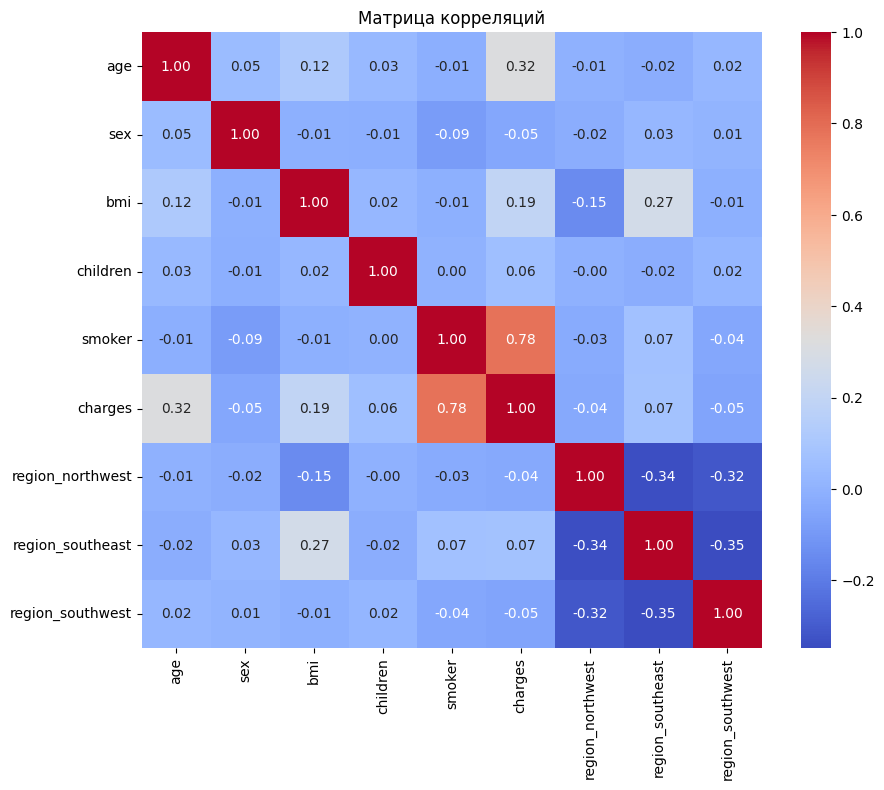

In [2]:
# 1. Проверка на пропуски
print("Пропуски в train:\n", train_df.isnull().sum())

# 2. Кодирование категориальных признаков
def preprocess_data(df):
    df_encoded = df.copy()
    
    # Бинарное кодирование
    df_encoded['sex'] = df_encoded['sex'].map({'male': 0, 'female': 1})
    df_encoded['smoker'] = df_encoded['smoker'].map({'no': 0, 'yes': 1})
    
    # One-Hot Encoding для региона (get_dummies)
    df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True) # drop_first=True чтобы избежать мультиколлинеарности
    
    # Преобразуем bool (от get_dummies) в int (0 и 1), если pandas ставит True/False
    cols = df_encoded.select_dtypes(include=['bool']).columns
    df_encoded[cols] = df_encoded[cols].astype(int)
    
    return df_encoded

train_encoded = preprocess_data(train_df)
test_encoded = preprocess_data(test_df)

# Убедимся, что колонки в тесте и трейне совпадают (порядок важен для матричных операций)
# Если в тесте не оказалось какого-то региона, get_dummies создаст меньше колонок.
# Добавим недостающие колонки с нулями, если они есть
for col in train_encoded.columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
# Оставим в тесте только те колонки, что есть в трейне, и в том же порядке
test_encoded = test_encoded[train_encoded.columns]

# 3. Парные корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(train_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляций")
plt.show()

In [3]:
# Разделение на X (признаки) и y (целевая переменная)
X_train_raw = train_encoded.drop('charges', axis=1).values
y_train = train_encoded['charges'].values

X_test_raw = test_encoded.drop('charges', axis=1).values
y_test = test_encoded['charges'].values

# Функция стандартизации
def standardize(X, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    # Добавляем eps, чтобы не делить на 0, если std=0
    X_scaled = (X - mean) / (std + 1e-8)
    return X_scaled, mean, std

# Обучаем scaler на тренировочных данных
X_train_scaled, train_mean, train_std = standardize(X_train_raw)

# Тестовые данные масштабируем параметрами из train (!), чтобы не было утечки данных
X_test_scaled, _, _ = standardize(X_test_raw, train_mean, train_std)

# Добавление столбца единиц (Bias term) для свободного члена w0
# Признак x0 = 1
X_train = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

print("Форма X_train:", X_train.shape)

Форма X_train: (1070, 9)


Веса (аналитически): [13214.1258132   3667.98588468   126.87434576  2062.82119905
   523.23706138  9477.91275996  -200.68458214  -499.64634368
  -534.36454133]


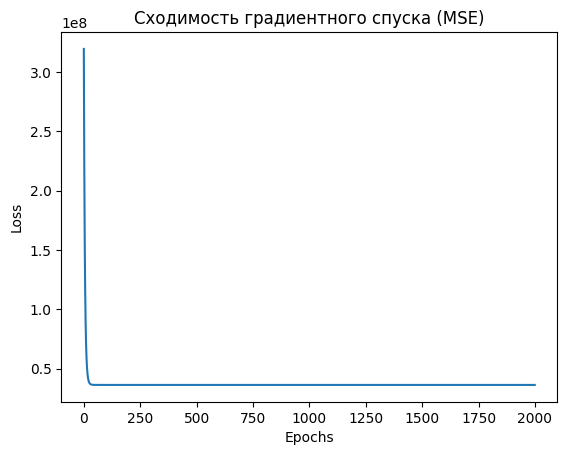

In [4]:
class LinearRegressionMy:
    def __init__(self):
        self.w = None
        
    def fit_analytic(self, X, y):
        # w = (X.T * X)^-1 * X.T * y
        # Используем псевдообратную матрицу (pinv) для стабильности, если определитель близок к 0
        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
        
    def fit_gradient_descent(self, X, y, lr=0.01, epochs=1000):
        m, n = X.shape
        self.w = np.zeros(n)  # Инициализация весов нулями
        self.loss_history = []
        
        for _ in range(epochs):
            # Предсказание: y_pred = X * w
            y_pred = X @ self.w
            
            # Ошибка
            error = y_pred - y
            
            # Градиент: (1/m) * X.T * error
            gradient = (1 / m) * (X.T @ error)
            
            # Обновление весов
            self.w -= lr * gradient
            
            # Запись функции потерь (MSE) для истории
            loss = np.mean(error ** 2)
            self.loss_history.append(loss)
            
    def predict(self, X):
        return X @ self.w

# Обучение аналитически
model_lr_analytic = LinearRegressionMy()
model_lr_analytic.fit_analytic(X_train, y_train)
print("Веса (аналитически):", model_lr_analytic.w)

# Обучение градиентным спуском
model_lr_gd = LinearRegressionMy()
model_lr_gd.fit_gradient_descent(X_train, y_train, lr=0.1, epochs=2000)

plt.plot(model_lr_gd.loss_history)
plt.title("Сходимость градиентного спуска (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [5]:
class RidgeRegressionMy:
    def __init__(self, alpha_reg=1.0):
        self.w = None
        self.alpha_reg = alpha_reg # Это лямбда (коэффициент регуляризации)
        
    def fit_analytic(self, X, y):
        m, n = X.shape
        I = np.eye(n)
        I[0, 0] = 0  # Не штрафуем bias (свободный член)
        
        # w = (X.T X + lambda*I)^-1 X.T y
        self.w = np.linalg.pinv(X.T @ X + self.alpha_reg * I) @ X.T @ y
        
    def fit_gradient_descent(self, X, y, lr=0.01, epochs=1000):
        m, n = X.shape
        self.w = np.zeros(n)
        
        for _ in range(epochs):
            y_pred = X @ self.w
            error = y_pred - y
            
            # Градиент с учетом регуляризации
            # d/dw (loss) + d/dw (lambda * w^2)
            # Производная регуляризатора: (lambda/m) * w, но bias не трогаем
            
            w_reg = self.w.copy()
            w_reg[0] = 0 # Зануляем bias для регуляризации
            
            gradient = (1 / m) * (X.T @ error) + (self.alpha_reg / m) * w_reg
            
            self.w -= lr * gradient
            
    def predict(self, X):
        return X @ self.w

# Зададим коэффициент регуляризации
lambda_val = 10.0

# Обучение Ridge аналитически
model_ridge_analytic = RidgeRegressionMy(alpha_reg=lambda_val)
model_ridge_analytic.fit_analytic(X_train, y_train)

# Обучение Ridge численно
model_ridge_gd = RidgeRegressionMy(alpha_reg=lambda_val)
model_ridge_gd.fit_gradient_descent(X_train, y_train, lr=0.1, epochs=2000)

print("Веса Ridge (аналитически):", model_ridge_analytic.w)

Веса Ridge (аналитически): [13214.1258132   3636.05312585   118.7909399   2042.05015346
   520.31542934  9388.19298092  -193.5373296   -477.54331906
  -522.95133246]


Модель                         | MSE                  | RMSE                
---------------------------------------------------------------------------
Константная модель             | 154006942.59         | 12409.95            
Linear Regression (Analytic)   | 37175951.41          | 6097.21             
Linear Regression (GD)         | 37175951.41          | 6097.21             
Ridge Regression (Analytic)    | 37236491.09          | 6102.17             


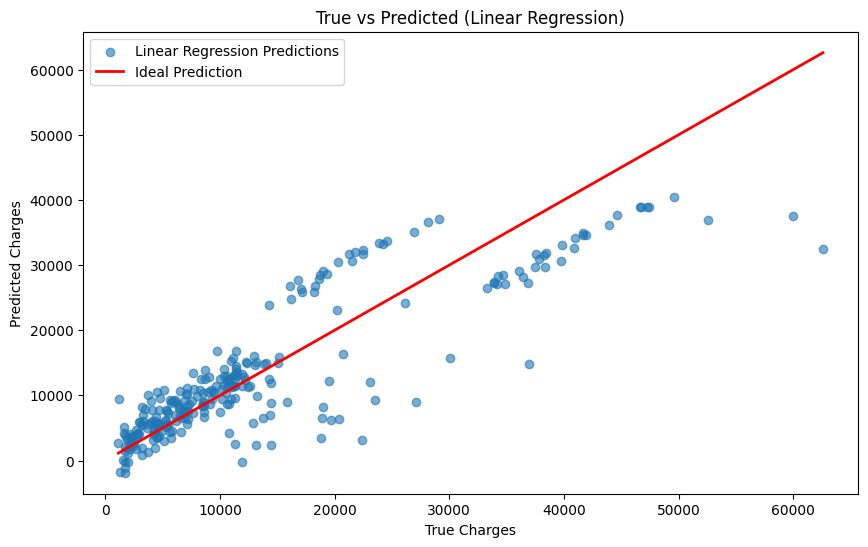

In [6]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# 1. Константная модель
y_pred_const = np.full_like(y_test, np.mean(y_train))
mse_const = mse(y_test, y_pred_const)

# 2. Обычная линейная регрессия (из пункта 2)
y_pred_lr = model_lr_analytic.predict(X_test)
mse_lr = mse(y_test, y_pred_lr)

# 3. Ridge регрессия (из пункта 3)
y_pred_ridge = model_ridge_analytic.predict(X_test)
mse_ridge = mse(y_test, y_pred_ridge)

# Сравнение численного и аналитического методов (для проверки)
y_pred_lr_gd = model_lr_gd.predict(X_test)
mse_lr_gd = mse(y_test, y_pred_lr_gd)

print(f"{'Модель':<30} | {'MSE':<20} | {'RMSE':<20}")
print("-" * 75)
print(f"{'Константная модель':<30} | {mse_const:<20.2f} | {np.sqrt(mse_const):<20.2f}")
print(f"{'Linear Regression (Analytic)':<30} | {mse_lr:<20.2f} | {np.sqrt(mse_lr):<20.2f}")
print(f"{'Linear Regression (GD)':<30} | {mse_lr_gd:<20.2f} | {np.sqrt(mse_lr_gd):<20.2f}")
print(f"{'Ridge Regression (Analytic)':<30} | {mse_ridge:<20.2f} | {np.sqrt(mse_ridge):<20.2f}")

# Визуализация предсказаний (сравнение с фактом)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Linear Regression Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Prediction')
plt.xlabel("True Charges")
plt.ylabel("Predicted Charges")
plt.title("True vs Predicted (Linear Regression)")
plt.legend()
plt.show()